In [ ]:
# This is the notebook for the multiclass model 

# Config

In [1]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

from externals.utils import set_seed, make_dirs, cfg_init
from externals.dataloading import read_image_mask, read_image_mask_downsampling, get_train_valid_dataset, get_transforms, CustomDataset
from externals.models import UNETR_Segformer, CNN3D_MulticlassSegformer, CNN3D_Segformer, Unet3D_Segformer, CNN3D_Unet, CNN3D_MANet, CNN3D_EfficientUnetplusplusb5, CNN3D_SegformerB4
from externals.metrics import AverageMeter, calc_fbeta
from externals.training_procedures import get_scheduler, scheduler_step, criterion, multiclass_criterion
from externals.postprocessing import post_process
from torch.optim.swa_utils import AveragedModel, SWALR

import monai

In [24]:
class CFG:
    is_multiclass = True
    
    # edit these so they match your local data path
    comp_name = 'vesuvius'
    comp_dir_path = './input'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    # ========================
    
    exp_name = 'unetr_multiclass_512_b5_continue'
    # ============== pred target =============
    target_size = 1
    # ============== model cfg =============
    model_name = 'unet'
    # ============== training cfg =============
    size = 512
    tile_size = 512
    stride = tile_size // 4
    in_chans = 16

    train_batch_size = 6
    valid_batch_size = train_batch_size
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    epochs = 10

    # adamW warmup
    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    # ============== fold =============
    valid_id = 1
    # ============== fixed =============
    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 100
    num_workers = 8
    seed = 42
    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'working/outputs/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

set dataset path


In [25]:
cfg_init(CFG)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model selection

In [26]:
# model = Unet3D_Segformer(CFG)
model = UNETR_MulticlassSegformer(CFG)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_fuse.wei

## train, val

In [29]:
def train_fn(train_loader, model, multiclass_criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()
    
    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        num_classes = 3  # Including background (class 0), and the two classes (class 1 and class 2)  
        
        # Convert the labels to one-hot encoding
        one_hot_encoded = torch.zeros(labels.size(0), num_classes, labels.size(2), labels.size(3))
        for class_idx in range(num_classes):
            one_hot_encoded[:, class_idx, :, :][labels.squeeze(dim=1)  == class_idx] = 1
        one_hot_encoded = one_hot_encoded.to(device)
        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = multiclass_criterion(y_preds, one_hot_encoded)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    # the loss here is binary, we only take the ink mask
    mask_pred = np.ones(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()
    losses_mask = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        labels_mask = torch.where(labels == 1, 1, 0)
        labels_ink = torch.where(labels == 2, 1, 0)
        
        with torch.no_grad():
            y_preds = model(images)
            logits_for_class_ink = y_preds[:, 2, :, :].unsqueeze(1)
            loss = criterion(logits_for_class_ink, labels) 
            
            logits_for_class_mask = y_preds[:, 1, :, :].unsqueeze(1)
            loss_m = criterion(logits_for_class_mask, labels) 
        losses.update(loss.item(), batch_size)
        losses_mask.update(loss_m.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(logits_for_class_ink).to('cpu').numpy() #we only validate on ink
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] *= y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))
        
        del logits_for_class_ink, logits_for_class_mask, y_preds, images, labels_mask, labels
        
    mask_pred = np.power(mask_pred, 1/mask_count)
    mask_pred[mask_pred==1] = 0
    
    # Visualizations at the end of each validation run 
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].imshow(valid_mask_gt)
    axs[0, 0].set_title('Ground Truth Mask')
    axs[0, 1].imshow(mask_pred)
    axs[0, 1].set_title('Predicted Mask')
    axs[1, 0].imshow(np.where(mask_pred >= 0.5, 1, 0))
    axs[1, 0].set_title('Thresholded Mask (>=0.5)')
    axs[1, 1].imshow(np.where(mask_pred >= 0.75, 1, 0))
    axs[1, 1].set_title('Thresholded Mask (>=0.75)')

    plt.tight_layout()
    plt.show()
    
    return losses.avg, losses_mask.avg, mask_pred

## main

In [30]:

def load_data(CFG):
    if CFG.valid_id == None:
        train_images, train_masks = get_train_valid_dataset(CFG)
    else:
        train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset(CFG)
        valid_xyxys = np.stack(valid_xyxys)
        fragment_id = CFG.valid_id

        valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
        valid_mask_gt = valid_mask_gt / 255
        
        pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
        valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

        valid_dataset = CustomDataset(
            valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))
        valid_loader = DataLoader(valid_dataset,
                        batch_size=CFG.valid_batch_size,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    train_dataset = CustomDataset(
        train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
    train_loader = DataLoader(train_dataset,
                            batch_size=CFG.train_batch_size,
                            shuffle=True,
                            num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                            )
    if CFG.valid_id == None:
        return train_loader
    else:
        return train_loader, valid_loader, valid_xyxys, valid_mask_gt


In [31]:
def return_augs(CFG):
        # ============== augmentation =============
    train_aug_list = [
            # A.RandomResizedCrop(
            #     size, size, scale=(0.85, 1.0)),
            A.Resize(CFG.size, CFG.size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=.5),
            A.RandomBrightnessContrast(p=0.25, brightness_limit=.2, contrast_limit=.2),
            A.ChannelDropout(channel_drop_range=(1, 2), p = .25),  
            A.ShiftScaleRotate(p=0.25),
            A.OneOf([
                    A.GaussNoise(var_limit=[10, 50]),
                    A.GaussianBlur(),
                    A.MotionBlur(),
                    ], p=0.25),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.25),
            A.CoarseDropout(max_holes=1, max_width=int(CFG.size * 0.05), max_height=int(CFG.size * 0.05), 
                            mask_fill_value=0, p=0.25),
            # A.Cutout(max_h_size=int(size * 0.6),
            #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
            A.Normalize(
                mean= [0] * CFG.in_chans,
                std= [1] * CFG.in_chans
            ),
            ToTensorV2(transpose_mask=True),
        ]

    valid_aug_list = [
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean= [0] * CFG.in_chans,
                std= [1] * CFG.in_chans
            ),
            ToTensorV2(transpose_mask=True),
        ]
    return train_aug_list, valid_aug_list

In [32]:
train_aug_list, valid_aug_list = return_augs(CFG)
CFG.train_aug_list, CFG.valid_aug_list = train_aug_list, valid_aug_list
cfg_pairs = {value:CFG.__dict__[value] for value in dir(CFG) if value[1] != "_"}
model_name = f"{CFG.exp_name}_{CFG.model_name}"


In [33]:
# Load pretrained weights 
# model.load_state_dict(torch.load('unetr_multiclass_512_b5_unet_final_Copy1.pth'))

<All keys matched successfully>

In [34]:
# model = CNN3D_Segformer(CFG)
model = torch.nn.DataParallel(model)
model.to(device)
swa_model = AveragedModel(model)
swa_start = 2

[]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


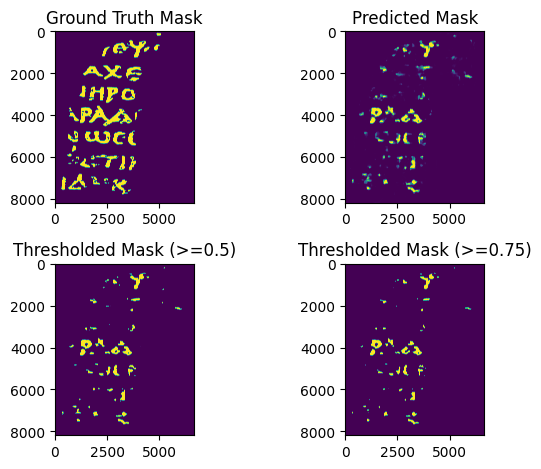

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.6405424613660469, precision: 0.7464603748410561, recall: 0.4086420812066898
th: 0.15, fbeta: 0.6397437575484041, precision: 0.7710905287290761, recall: 0.38051250317850616
th: 0.2, fbeta: 0.6378413135331725, precision: 0.7912708329605166, recall: 0.3592417970529827
th: 0.25, fbeta: 0.6323453948040212, precision: 0.8047533691792039, recall: 0.3405463049698812
th: 0.3, fbeta: 0.6256671625672966, precision: 0.8162484796957025, recall: 0.3235356583795526
th: 0.35, fbeta: 0.617567556646252, precision: 0.825683243379886, recall: 0.3075361812884994
th: 0.4, fbeta: 0.6090264206944873, precision: 0.8337746996355729, recall: 0.29306591311790986
th: 0.45, fbeta: 0.600717974948407, precision: 0.8409421952639647, recall: 0.28037638204661836
th: 0.5, fbeta: 0.5922512532912856, precision: 0.8474468932237694, recall: 0.2686635594285073
th: 0.55, fbeta: 0.5841051327416565, precision: 0.8543984072988563, recall: 0.257847285873747
th: 0.6, fbeta: 0.5765101376069935, precision: 0.8619495

  0%|          | 0/1404 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


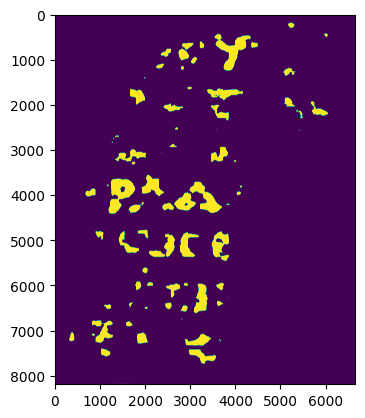

th: 0.5, fbeta: 0.6150345896120548, precision: 0.8319362174013544, recall: 0.3010775444701051
th: 0.55, fbeta: 0.6078111403694878, precision: 0.8401843464673278, recall: 0.28858241864797973
th: 0.6, fbeta: 0.6000715055569074, precision: 0.8483126438740846, recall: 0.2764777889188325
th: 0.65, fbeta: 0.5915339053616088, precision: 0.8576935623602772, recall: 0.26393902492420646
th: 0.7, fbeta: 0.5808156483695379, precision: 0.8669863634744748, recall: 0.25033065748257877
th: 0.75, fbeta: 0.5691738207077878, precision: 0.8754168241755231, recall: 0.23723564725478957
th: 0.8, fbeta: 0.5566668036492556, precision: 0.8852024885171766, recall: 0.22405991577228881
th: 0.85, fbeta: 0.54354540066865, precision: 0.8964867003543403, recall: 0.21111342516163709
th: 0.9, fbeta: 0.5281493778054298, precision: 0.911554675394018, recall: 0.19690124026017172
th: 0.95, fbeta: 0.5005026236134508, precision: 0.9274129538077938, recall: 0.1761605600066522
th: 1.0, fbeta: 0.0, precision: 0.0, recall: 0.0
be

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


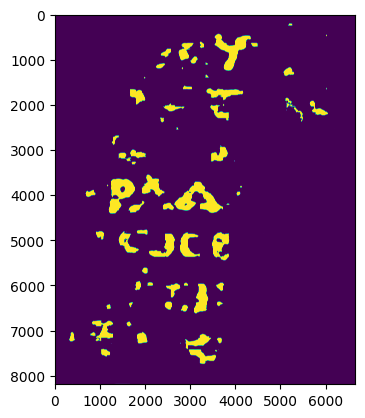

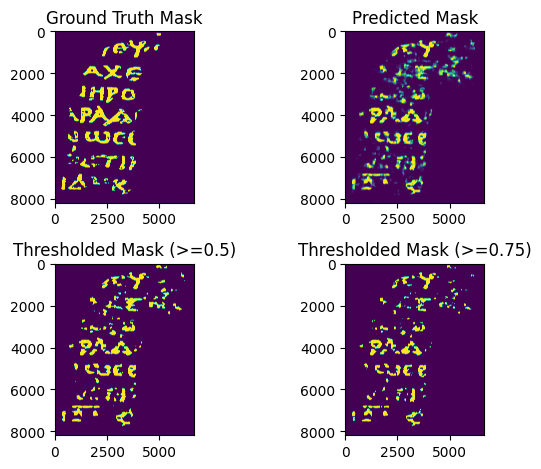

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.5383233638065731, precision: 0.5096377057870888, recall: 0.6947957452581511
th: 0.15, fbeta: 0.5593379133828997, precision: 0.5379924041854595, recall: 0.6649028479420109
th: 0.2, fbeta: 0.5734860613331456, precision: 0.5585605530415666, recall: 0.6421652998979239
th: 0.25, fbeta: 0.5845311358805124, precision: 0.575971674410945, recall: 0.6215169527733435
th: 0.3, fbeta: 0.5931926728819744, precision: 0.5909591376974099, recall: 0.6023390060449126
th: 0.35, fbeta: 0.5993554754981832, precision: 0.6034186213781881, recall: 0.5836744165303202
th: 0.4, fbeta: 0.6045982373920659, precision: 0.6148621494906367, recall: 0.5667916878447897
th: 0.45, fbeta: 0.6090347729333841, precision: 0.6258150145048594, recall: 0.5500760203175022
th: 0.5, fbeta: 0.6130876238863274, precision: 0.6368591988008846, recall: 0.5334755350910213
th: 0.55, fbeta: 0.6162240406103926, precision: 0.6473295276357487, recall: 0.5169081998925773
th: 0.6, fbeta: 0.6196501944882159, precision: 0.6586759

  0%|          | 0/1404 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


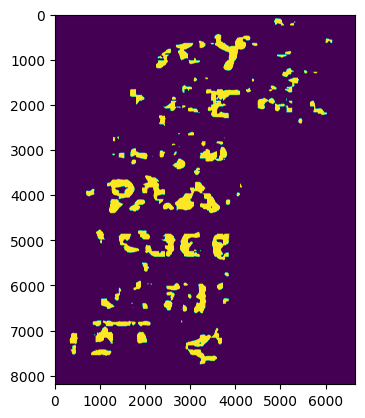

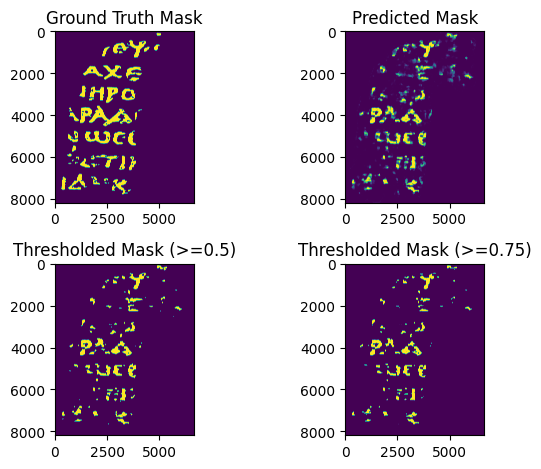

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.6173018683837617, precision: 0.6253214992863487, recall: 0.5872175364761049
th: 0.15, fbeta: 0.6354896497698274, precision: 0.6602703484141721, recall: 0.5525733224296225
th: 0.2, fbeta: 0.6459740275038854, precision: 0.6854575485002623, recall: 0.5250391338880469
th: 0.25, fbeta: 0.6533270786325113, precision: 0.7070998628014372, recall: 0.5009738991278341
th: 0.3, fbeta: 0.6580212581929893, precision: 0.7248298422720614, recall: 0.4807952710445915
th: 0.35, fbeta: 0.6615912871947678, precision: 0.7415711970718304, recall: 0.4622211417759983
th: 0.4, fbeta: 0.6637358424526195, precision: 0.7564598217385774, recall: 0.4453927266957262
th: 0.45, fbeta: 0.6638640481961303, precision: 0.7691494316299631, recall: 0.4290020043585189
th: 0.5, fbeta: 0.6621311424838873, precision: 0.779879545307854, recall: 0.41283883729851467
th: 0.55, fbeta: 0.6590985934624624, precision: 0.7897844666160835, recall: 0.39661798544396015
th: 0.6, fbeta: 0.6553756522041666, precision: 0.80001

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


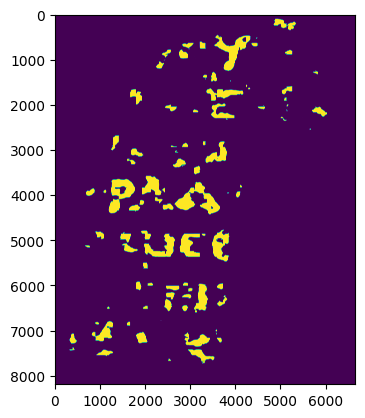

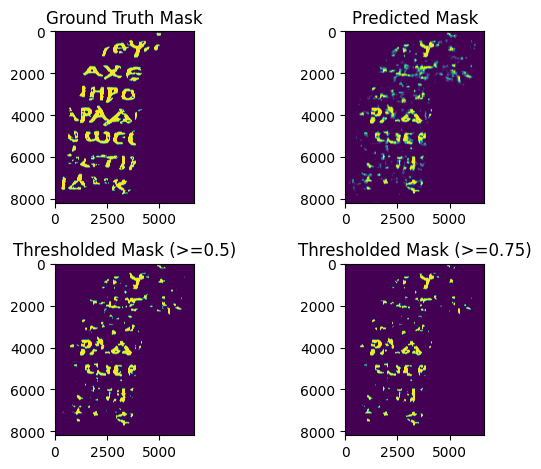

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.5580251993021136, precision: 0.5530755401950351, recall: 0.5787845064624224
th: 0.15, fbeta: 0.5737604094143886, precision: 0.5809349594050591, recall: 0.5467885488930199
th: 0.2, fbeta: 0.5845805200564211, precision: 0.6028339096564574, recall: 0.5214613656078733
th: 0.25, fbeta: 0.5926595837938218, precision: 0.6213235935365218, recall: 0.5003631520011186
th: 0.3, fbeta: 0.5989906123905501, precision: 0.6382280696504514, recall: 0.48079377273823953
th: 0.35, fbeta: 0.6034798317992167, precision: 0.6537751713002882, recall: 0.4615021420153541
th: 0.4, fbeta: 0.6074397088334427, precision: 0.6694638742097649, recall: 0.443222242656626
th: 0.45, fbeta: 0.6090501586766891, precision: 0.6829659708183837, recall: 0.4250689501846381
th: 0.5, fbeta: 0.6091261266582735, precision: 0.6943969997606101, recall: 0.40850573532866197
th: 0.55, fbeta: 0.6093206677646232, precision: 0.7060093894797697, recall: 0.39369010754394684
th: 0.6, fbeta: 0.608827891924879, precision: 0.71777

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


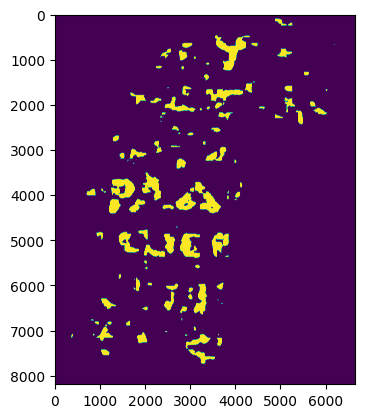

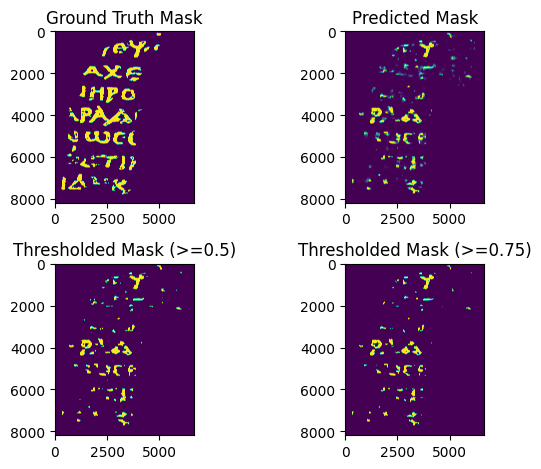

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.6407120274476898, precision: 0.7166866685797009, recall: 0.44995300936619403
th: 0.15, fbeta: 0.6417884633148551, precision: 0.7402712811511452, recall: 0.41890510514099083
th: 0.2, fbeta: 0.6418914007233585, precision: 0.7590591299797935, recall: 0.3968781288843183
th: 0.25, fbeta: 0.6412421809432254, precision: 0.7748662148624257, recall: 0.37949964808458486
th: 0.3, fbeta: 0.6403516875301769, precision: 0.7898060143630948, recall: 0.3644931735282896
th: 0.35, fbeta: 0.6366745335122933, precision: 0.7999824739104974, recall: 0.35050161423714954
th: 0.4, fbeta: 0.6322924894274239, precision: 0.8091777467368083, recall: 0.3373481700616341
th: 0.45, fbeta: 0.6271191752228673, precision: 0.8173054039763121, recall: 0.32481408827435787
th: 0.5, fbeta: 0.6214461877533405, precision: 0.8241355966901739, recall: 0.3132808751301873
th: 0.55, fbeta: 0.6147735339195411, precision: 0.830293734770875, recall: 0.30162779747786045
th: 0.6, fbeta: 0.6082287248546221, precision: 0.8

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


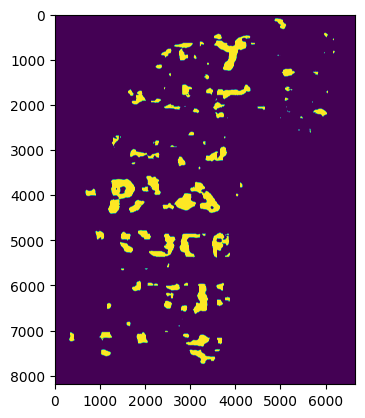

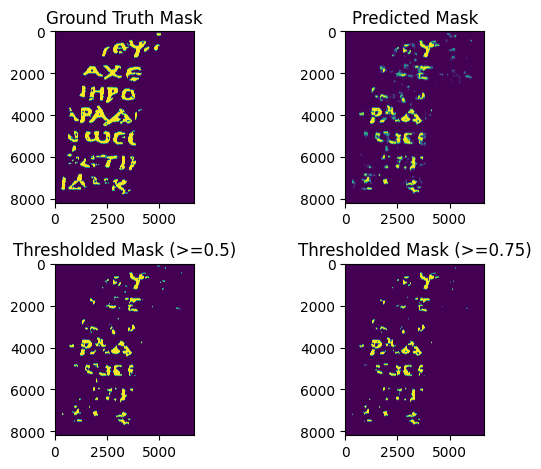

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.6405760145184141, precision: 0.6748203965855183, recall: 0.5325209266565322
th: 0.15, fbeta: 0.6486322662412769, precision: 0.7016446325319151, recall: 0.4981265551942384
th: 0.2, fbeta: 0.6518659889745435, precision: 0.7209347364998665, recall: 0.4712939486019654
th: 0.25, fbeta: 0.6546461001854886, precision: 0.7377957831311932, recall: 0.4512554121626306
th: 0.3, fbeta: 0.6552405934522201, precision: 0.750847180930539, recall: 0.4341509341370109
th: 0.35, fbeta: 0.6534969934561635, precision: 0.7619998183390533, recall: 0.41637633859547946
th: 0.4, fbeta: 0.6494061353197671, precision: 0.7708960384814955, recall: 0.3983357936764761
th: 0.45, fbeta: 0.6459914246590313, precision: 0.7796389960440838, recall: 0.3832405444688275
th: 0.5, fbeta: 0.6422204104938525, precision: 0.7880470013097277, recall: 0.36907012485692287
th: 0.55, fbeta: 0.6390905268117082, precision: 0.7969277362551023, recall: 0.3566077744862465
th: 0.6, fbeta: 0.6361224570971329, precision: 0.80688

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


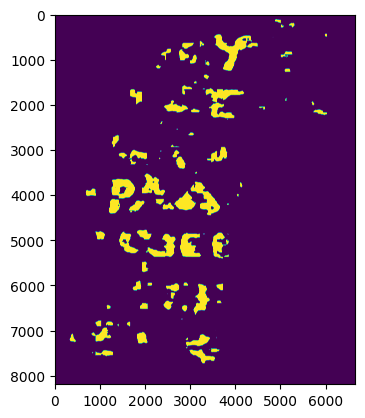

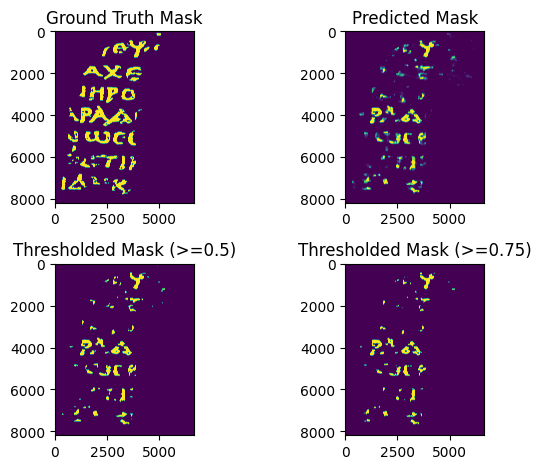

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.6494355001082035, precision: 0.7255413402614426, recall: 0.4575091555873951
th: 0.15, fbeta: 0.6491497896249904, precision: 0.7459667584895509, recall: 0.4273343893887934
th: 0.2, fbeta: 0.6489381251102028, precision: 0.7629019323678647, recall: 0.40623523934056877
th: 0.25, fbeta: 0.6469821692515186, precision: 0.7758107254548329, recall: 0.3887784720339457
th: 0.3, fbeta: 0.6435813101600333, precision: 0.7860861864956987, recall: 0.3730801545196354
th: 0.35, fbeta: 0.6403849581082754, precision: 0.7962300857441218, recall: 0.3591966605741301
th: 0.4, fbeta: 0.6376127631963956, precision: 0.8066844498149813, recall: 0.34685623488284395
th: 0.45, fbeta: 0.6338652661110623, precision: 0.8162348664373342, recall: 0.33473755853164716
th: 0.5, fbeta: 0.6286546240731546, precision: 0.8244896825231887, recall: 0.3223875811373674
th: 0.55, fbeta: 0.6217763622952324, precision: 0.8320590566833527, recall: 0.30921746830368646
th: 0.6, fbeta: 0.6136141764571402, precision: 0.83

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipykernel_1613/886825517.py:77: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


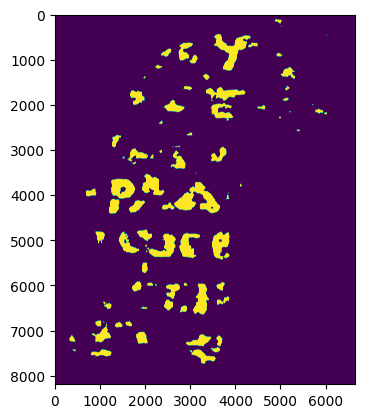

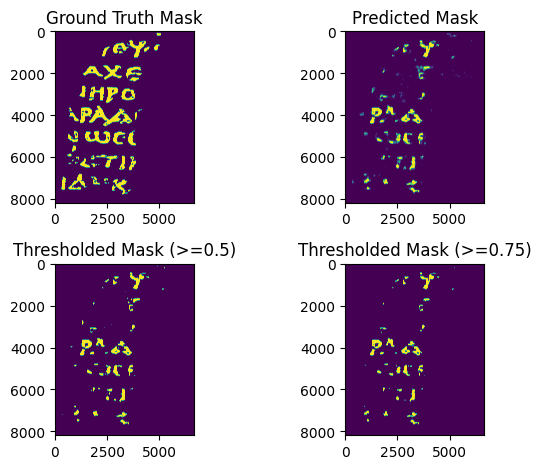

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.6695272679458608, precision: 0.7934791820584878, recall: 0.4120748883473118
th: 0.15, fbeta: 0.6680846156938492, precision: 0.8154491242436929, recall: 0.3877948339138875
th: 0.2, fbeta: 0.665415542810545, precision: 0.8309143851122249, recall: 0.37037065477041947
th: 0.25, fbeta: 0.660066012400288, precision: 0.8429206741683942, recall: 0.35342424806493095
th: 0.3, fbeta: 0.6538289081464257, precision: 0.8529094980260721, recall: 0.33814714192381384
th: 0.35, fbeta: 0.6474943184693929, precision: 0.8605943166495041, recall: 0.32531096411832483
th: 0.4, fbeta: 0.6413206713011027, precision: 0.867289052555227, recall: 0.31405137917167997
th: 0.45, fbeta: 0.6350271519639816, precision: 0.8737979543940093, recall: 0.30341546424403626
th: 0.5, fbeta: 0.6282935845311813, precision: 0.8791391499525046, recall: 0.2934270049487309
th: 0.55, fbeta: 0.6217653499419129, precision: 0.8840454645979104, recall: 0.284348954050532
th: 0.6, fbeta: 0.6143210892656958, precision: 0.8886

  0%|          | 0/1404 [00:00<?, ?it/s]

th: 0.75, fbeta: 0.6008724578867851, precision: 0.8964370703230664, recall: 0.25913770221936794
th: 0.8, fbeta: 0.5919847880630286, precision: 0.9019145531180296, recall: 0.24931592950571752
th: 0.85, fbeta: 0.581753775901541, precision: 0.9094776102801798, recall: 0.23830019391785331
th: 0.9, fbeta: 0.5690474590455493, precision: 0.918435075425882, recall: 0.22567321713675592
th: 0.95, fbeta: 0.5466905103576282, precision: 0.930081840124958, recall: 0.206396756765684
th: 1.0, fbeta: 0.0, precision: 0.0, recall: 0.0
best_th: 0.1, fbeta: 0.668953465725208, precision: 0.7744490072055306, recall: 0.4330354450579807, auc: 1.0


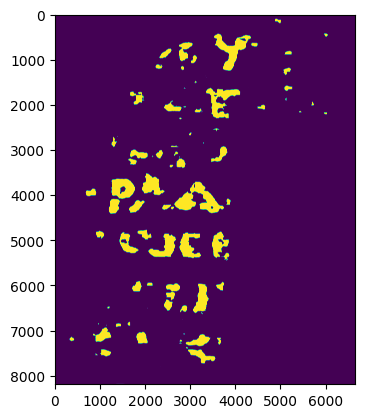

In [35]:
best_counter = 0
best_loss = np.inf
best_score = 0
optimizer = AdamW(model.parameters(), lr=CFG.lr)
swa_scheduler = SWALR(optimizer, swa_lr=0.05)
scheduler = get_scheduler(CFG, optimizer)
if CFG.valid_id == None:
    train_loader = load_data(CFG)
else:
    train_loader, valid_loader, valid_xyxys, valid_mask_gt = load_data(CFG)

for epoch in range(CFG.epochs):
    # train
    avg_loss = train_fn(train_loader, model, multiclass_criterion, optimizer, device)
    if epoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        # torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Update bn statistics for the swa_model at the end
    if CFG.valid_id != None:
        # eval
        avg_val_loss, avg_mask_loss, mask_pred = valid_fn(
            valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

        scheduler_step(scheduler, avg_val_loss, epoch)

        best_dice, best_th, best_metrics = calc_fbeta(valid_mask_gt, mask_pred)

        # score = avg_val_loss
        score = best_dice

#         print({"dice":best_dice, "avg_train_loss":avg_loss, "avg_val_loss":avg_val_loss, "avg_mask_val_loss": avg_mask_loss, "ctp":best_metrics[0],
#                    "cfp":best_metrics[1], "ctn":best_metrics[2], "cfn":best_metrics[3]})

        update_best = score > best_score
        if update_best:
            best_loss = avg_val_loss
            best_score = score
            best_counter = 0
            torch.save(model.module.state_dict(),
                    CFG.model_dir + f"{model_name}_best.pth")
        else:
            best_counter += 1
            if best_counter > 8:
                break
        torch.save(model.module.state_dict(),
                CFG.model_dir + f"{model_name}_final.pth")
        plt.imshow(mask_pred > best_th)
    else:        
        print({"avg_train_loss":avg_loss})
        scheduler_step(scheduler, avg_loss, epoch)
        if (epoch % 5) == 0:
            torch.save(model.module.state_dict(),
                CFG.model_dir + f"{model_name}_{epoch}_final.pth")
torch.optim.swa_utils.update_bn(train_loader, swa_model)
torch.save(swa_model.module.state_dict(),
    CFG.model_dir + f"{model_name}_final_swa.pth")
wandb.log({"results": wandb.Image(plt)})